## Motivation {.unnumbered}

Before futher analysis, identifying and removing poor quality cells is a critical step to ensure quality of the data and prevent misinformative results. Crucial parameters indicative of poor quality cells include the fraction of mitochondrial, ribosomal, haemoglobin, T/B-cell recepter (TCR/BCR) reads. High mitochondrial fractions is a typical characteristic of apoptotic cells in scRNAseq data. High ribosomal & haemoglobin fractions indicates poor sample quality and RBC contamination. Cells with high TCR & BCR fractions are indicative of T/B-cell doublets.  

In [5]:
## set up environment
suppressMessages({
source("/camp/home/hungm/working/Matthew/library/R/functions/Seurat/processing.R")
source("/camp/home/hungm/working/Matthew/library/R/functions/Seurat/plotting.R")
setwd("/nemo/lab/caladod/working/Matthew/project/matthew/MH_GSE155224")})

## import seurat objects
obj <- qread("seurat/20240826_GSE155224_doublets.qs")

In [53]:
obj <- qread("seurat/20240826_GSE155224_doublets.qs")

## Calculate Gene Fractions {#sec-calculate_gene_fractions}
  
The function below will perform the calculations of key quality control parameters for every cell but will not filter any cells yet. This is done by calculating the no. of selected reads over the no. of total reads for every cell.

In [52]:
# run calculate gene fractions if haven't done so already
obj <- calculate_fractions(obj)

## Remove VDJ Genes {#sec-remove_vdj_genes}
In the case of T/B-cells, removing VDJ genes could be critical prior to subsequence steps to avoid cell clustering by VDJ genes, especially by isotype such as IgG and IgM for B-cells. Below is a wrapper function to remove VDJ genes from the Seurat object.

:::{.callout-warning}
Before removing VDJ genes, please run Seurat::NormalizeData() to ensure library size is normalized with VDJ genes included.
:::

In [54]:
# normalize counts and remove vdj genes
obj <- NormalizeData(obj)
obj <- remove_vdj_genes(obj, bcr = T, tcr = T)

Normalizing layer: counts

Warning message:
“Different cells and/or features from existing assay RNA”
Warning message:
“Different cells and/or features from existing assay RNA”


## Filter By Gene Fractions {#sec-filter_by_gene_fractions}

Following @sec-calculate_gene_fractions, we will now set thresholds to remove poor quality cells mentioned above. There are generally 2 approaches - either hard and soft threshold could be set to remove cells. The difference between the methods is that using a soft threshold means that you are defining poor quality cells based on the distribution of the population, which ensures a good proportion of cells will remain and hopefully are the cells of interest. Generally we recommend using a <u>soft</u> threshold for quality control, especially in the case where users have multiple sequencing runs, as these threshold may subject to change depending on cell populations, batch effects etc.

For both approaches, a threshold is set for the following essential quality control parameters, including nFeatures_RNA, nCount_RNA, mitochondrial, haemoglobin fraction. Typically mitochondrial fraction threshold is set at 10% for human and 5% for mouse.

:::{.callout-warning}
If VDJ genes were removed earlier, recalculating nFeature and nCount is critical to remove cells that only contain VDJ genes which are likely empty droplets contaminated with RNA. This was done automatically in the Seurat object when VDJ were first removed.
:::

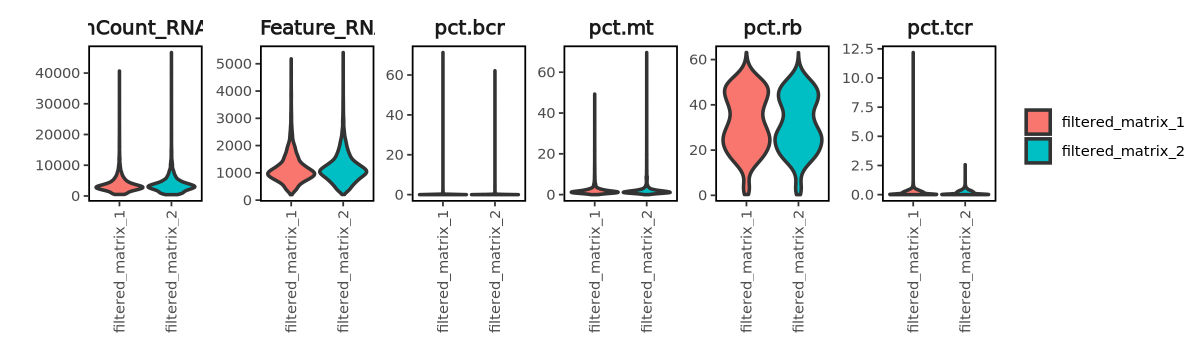

In [55]:
## Visualize each quality control parameter for each sequencing run
options(repr.plot.width=10, repr.plot.height= 3)
cols <- c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    ggplot(aes(x = samples, y = values, fill = samples)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~ measures, scales = "free", ncol = 6) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = "")) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()
    

### Hard Threshold
> Given both our sequencing runs contain the similar composition of cells and distributions of the quality control parameters, we can apply the same hard thresholds to both runs. 

Warning message:
“Removed 47187 rows containing missing values or values outside the scale range
(`geom_hline()`).”


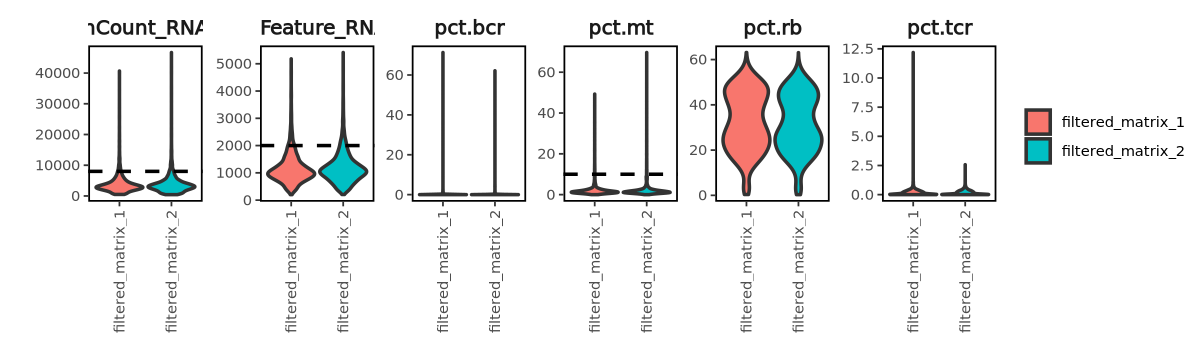

In [56]:
## Visualize each quality control parameter for each sequencing run
options(repr.plot.width=10, repr.plot.height= 3)
cols <- c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%

    ## define hard threshold
    mutate(
        yintercept = case_when(
            measures == "nCount_RNA" ~ 8000,
            measures == "nFeature_RNA" ~ 2000,
            measures == "pct.mt" ~ 10,
            .default = NULL)) %>%
            
    ggplot(aes(x = samples, y = values, fill = samples)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~ measures, scales = "free", ncol = 6) +
    geom_hline(aes(yintercept = yintercept), color = "black", linetype = "dashed", size = 1) + 
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = ""), color = guide_none()) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()

> After visualization we removed cells based on the following criteria : 
> 
> * nCount_RNA > 8000
> * nFeature_RNA < 200 or > 2000
> * pct.mt > 10%
> * pct.hb > 0%
> 
> \> 90% cells remains from each sequencing run after quality control filter by hard threshold.

In [57]:
## set hard threshold
obj@meta.data <- obj@meta.data %>%
    mutate(hardqc = case_when(
        .$nCount_RNA > 8000 ~ "Fail",
        .$nFeature_RNA > 2000 ~ "Fail",
        .$nFeature_RNA < 200 ~ "Fail",
        .$pct.mt > 10 ~ "Fail",
        .$pct.hb > 0 ~ "Fail",
        .default = "Pass"))
qc_report(obj, column = "hardqc", sample = "samples")

91% (6827) of cells remains - filtered_matrix_1

90.2% (7420) of cells remains - filtered_matrix_2



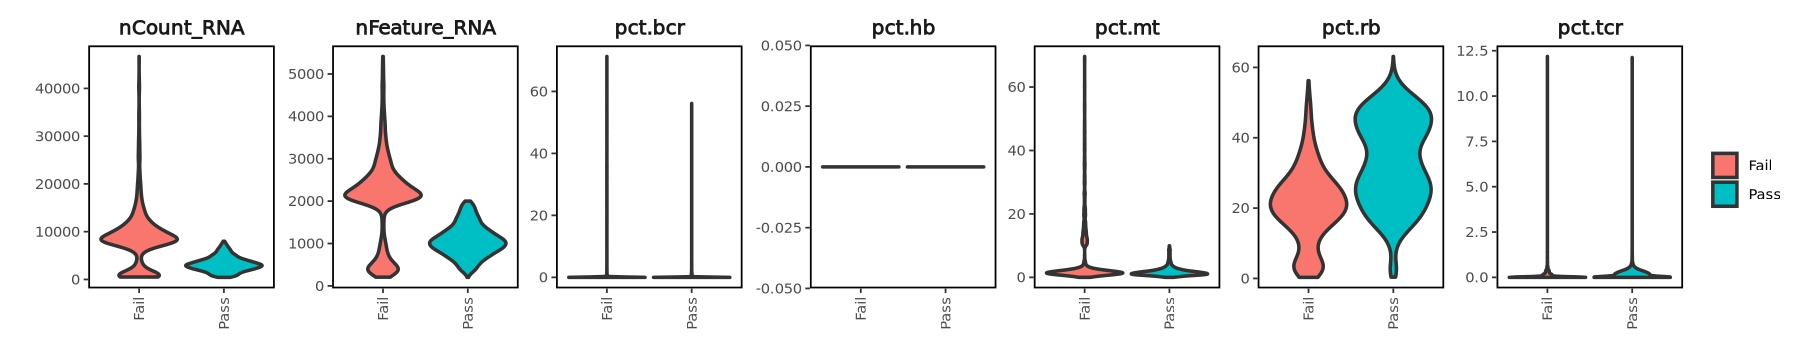

In [58]:
## Visualize the quality control parameters for good/poor quality cells
options(repr.plot.width=15, repr.plot.height= 3)
cols <- c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.rb", "pct.hb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    ggplot(aes(x = hardqc, y = values, fill = hardqc)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~measures, scales = "free", ncol = 7) +
    guides(fill = guide_legend(title = "")) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    xlab("") +
    ylab("") +
    theme_border() + 
    facet_aes()
    

### Soft Threshold

As a comparison, we will perform soft threshold cutoff to remove outlier (poor quality) cells based on population distribution. To do so, we have adapted the median absolute deviation (MAD) method [[see details]](https://bioconductor.org/books/3.13/OSCA.basic/quality-control.html) to determine outlier cells from each sample based on the quality control filter mentioned above. Below is a wrapper function to calculate thresholds for the specified quality control parameters within 5 MAD deviations and determine outlier cells. Note the function does not perform the filtering yet.

> \> 85% cells remains from each sample after quality control filter by soft threshold.

In [59]:
## calculate mad and determine outlier cells
obj <- calculate_mad(obj, columns = c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.hb"), stdev = 5, samples = "samples")

87.8% (6585) of cells remains - filtered_matrix_1

88% (7237) of cells remains - filtered_matrix_2



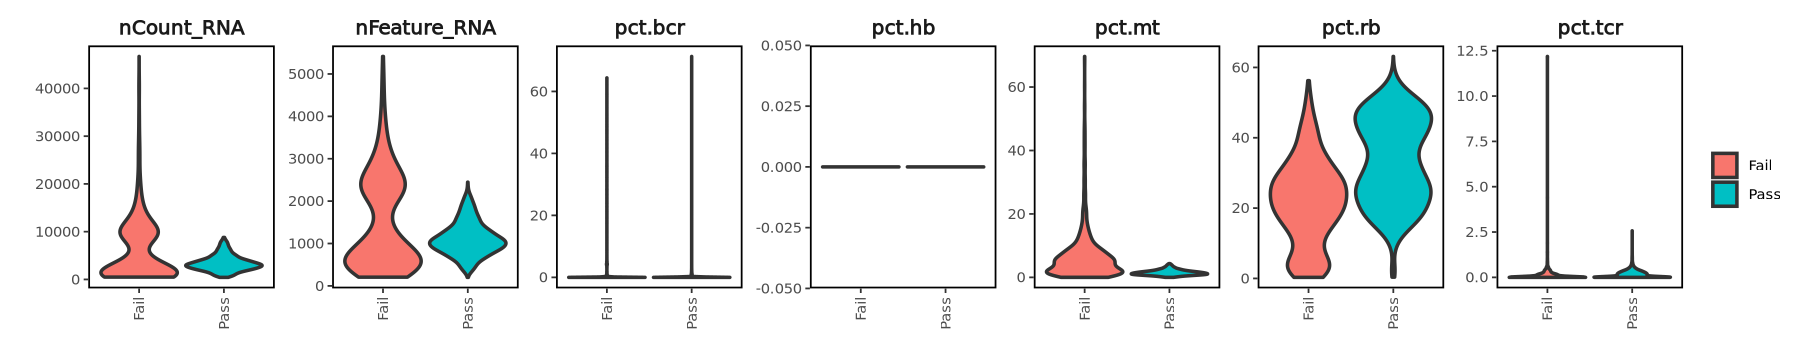

In [60]:
## Visualize the quality control parameters for good/poor quality cells
options(repr.plot.width=15, repr.plot.height= 3)
cols <- c("nFeature_RNA", "nCount_RNA", "pct.mt", "pct.rb", "pct.hb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    ggplot(aes(x = softqc, y = values, fill = softqc)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~measures, scales = "free", ncol = 7) +
    guides(fill = guide_legend(title = "")) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    xlab("") +
    ylab("") +
    theme_border() + 
    facet_aes()
    

### Inspecting QC
Finally we will move forward with the soft threshold, Here we will do a final inspection to ensure we are keeping the high quality cells.

In [61]:
# make scatter plots
fs1.plot <- list()
fs2.plot <- list()
fs3.plot <- list()
fs4.plot <- list()

obj_list <- SplitObject(obj, split.by = "samples")
for(x in 1:length(obj_list)){
    Idents(obj_list[[x]]) <- "samples"
    fs1.plot[[x]] <- FeatureScatter(obj_list[[x]], group.by = "softqc", "nCount_RNA", "nFeature_RNA", pt.size = 0.5, plot.cor = T) + NoLegend()
    fs2.plot[[x]] <- FeatureScatter(obj_list[[x]], group.by = "softqc", "nCount_RNA", "pct.mt", pt.size = 0.5, plot.cor = T) + NoLegend()
    fs3.plot[[x]] <- FeatureScatter(obj_list[[x]], group.by = "softqc", "pct.rb", "pct.mt", pt.size = 0.5, plot.cor = T) + NoLegend()}

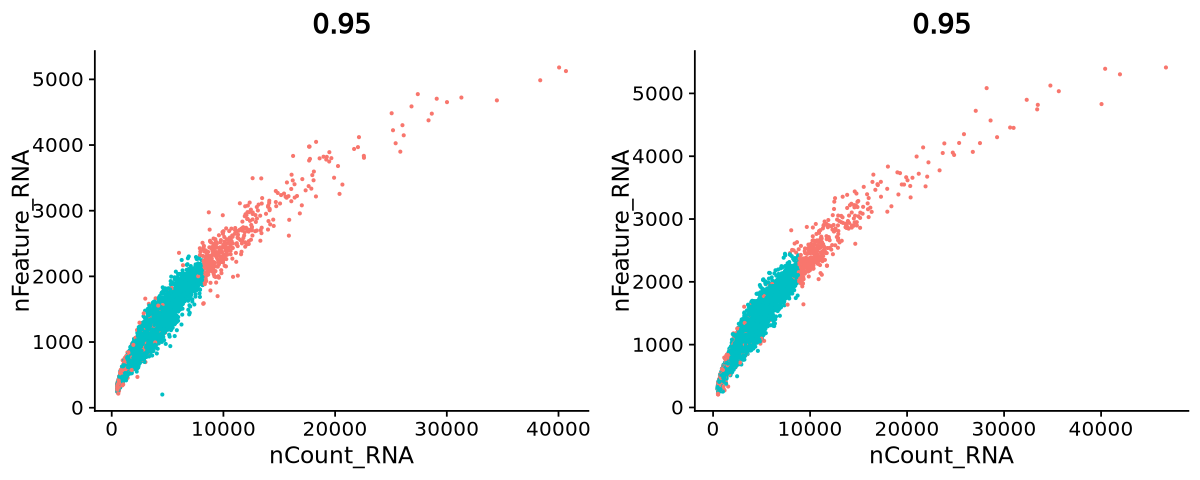

In [62]:
# nCount_RNA vs nFeature_RNA
options(repr.plot.width=10, repr.plot.height=4)
plot_grid(plotlist = fs1.plot, ncol = 2)

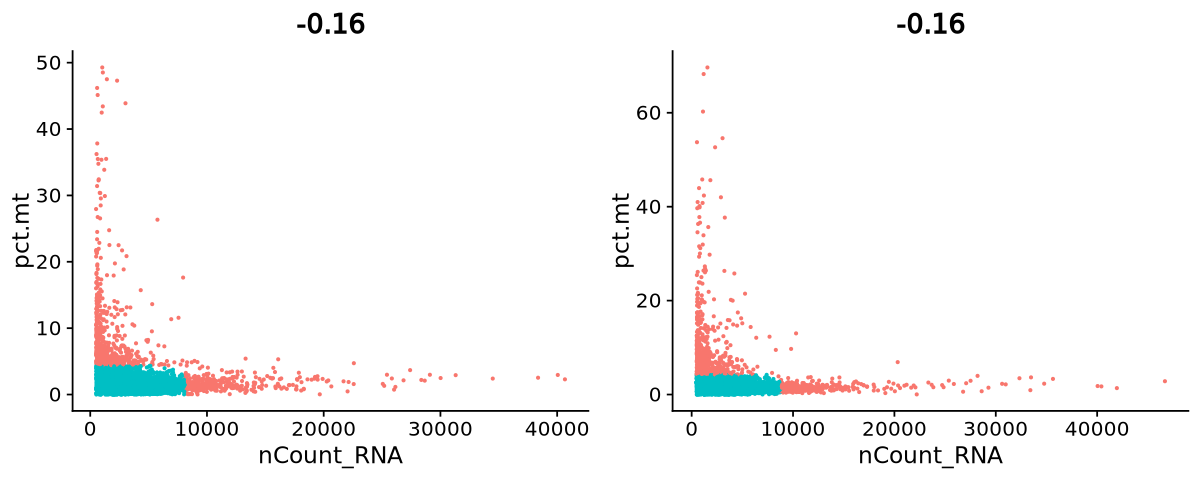

In [63]:
# nCount_RNA vs mitochondrial fraction
options(repr.plot.width=10, repr.plot.height=4)
plot_grid(plotlist = fs2.plot, ncol = 2)

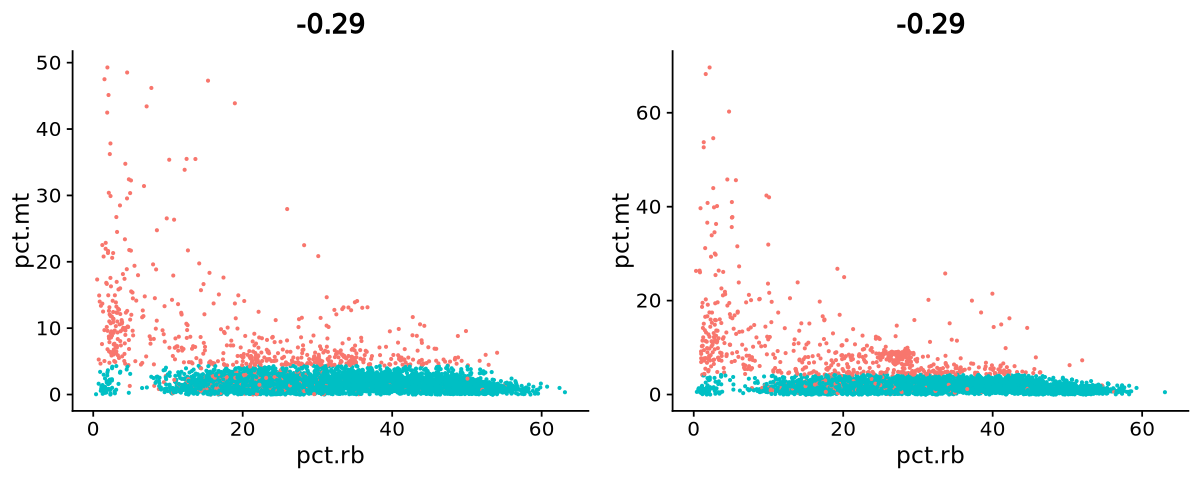

In [64]:
# ribosomal fraction vs mitochondrial fraction
options(repr.plot.width=10, repr.plot.height=4)
plot_grid(plotlist = fs3.plot, ncol = 2)

## Remove Poor Quality Cells {#sec-filtercells}
Combining the soft threshold filters together with outputs from MULTIseqDemux, DoubletFinder, T/B Doublet (see previous chapters), we will remove the poor quality cells altogether.

> \> 60% of cells remain from each sample after all quality control filters.

In [65]:
## make a column of cells to keep, putting together outputs from multiseqdemux, doubletfinder, t/b doublets and quality control
obj@meta.data <- obj@meta.data %>%
    mutate(finalqc = ifelse(
        MULTI.global == "Singlet" & DoubletFinder == "Singlet" & TB_Doublet == "Singlet" & softqc == "Pass", "Pass", "Fail"))
qc_report(obj, column = "finalqc", sample = "samples")

62% (4653) of cells remains - filtered_matrix_1

62.6% (5150) of cells remains - filtered_matrix_2



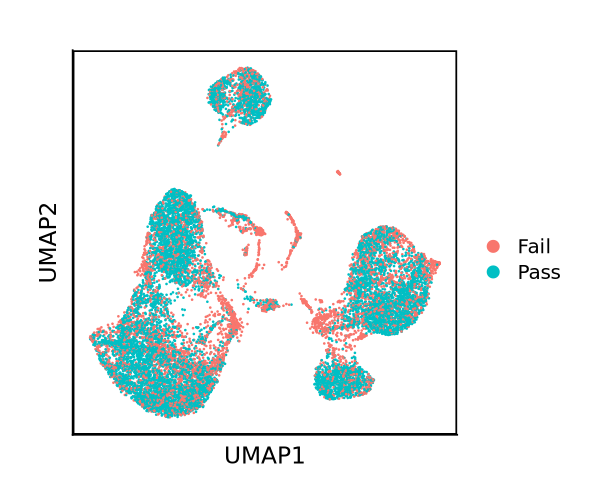

In [66]:
# visualize poor quality cells on UMAP
options(repr.plot.width=5, repr.plot.height=4)
scUMAP(obj, group.by = "finalqc", reduction = "umap")

In [67]:
## remove poor quality cells
obj <- subset(obj, subset = finalqc == "Pass")
obj

An object of class Seurat 
17895 features across 9803 samples within 5 assays 
Active assay: RNA (17437 features, 0 variable features)
 2 layers present: counts, data
 4 other assays present: HTO, ADT, BCR, TCR
 3 dimensional reductions calculated: pca, harmony, umap

## Calculate Cell Cycle {#sec-calculate_cell_cycle}
Finally we will calculate cycle/profileration scores for each cell for every cell and assign cells to a proliferation state. We will perform Seurat's cell cycle scoring pipeline with the "calculate_cellcycle" wrapper function.

In [68]:
## assign cell cycle phase
obj <- calculate_cellcycle(obj, remove_genes = F)

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”


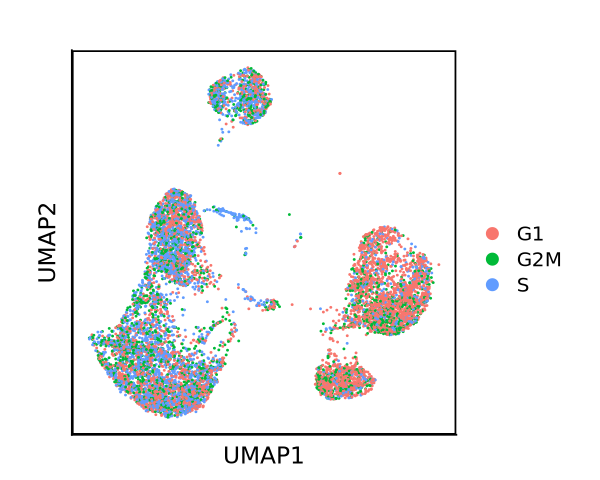

In [69]:
## visualize cell cycle phase on UMAP
options(repr.plot.width=5, repr.plot.height=4)
scUMAP(obj, group.by = "Phase", reduction = "umap")

> Both samples contain 50% of cycling cells at G2M/S Phase. The proportion of cycling cells are consistent across 2 sequencing runs.

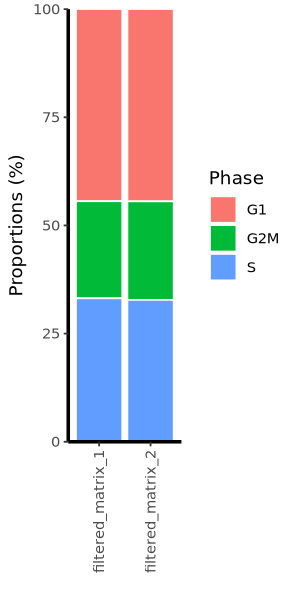

In [70]:
## calculate proportions of cells at each phase
options(repr.plot.width=2.5, repr.plot.height=5)
obj@meta.data %>%
    group_by(samples, Phase) %>%
    summarize(count = n()) %>%
    group_by(samples) %>%
    mutate(pct = count*100/sum(count)) %>%
    ggplot(aes(x = samples, y = pct, fill = Phase)) +
    geom_col(color = "white", position = "stack") +
    theme_line() +
    xlab("") +
    ylab("Proportions (%)")

## Session Info {.unnumbered}

In [71]:
qsave(obj, file = "seurat/20240826_GSE155224_qc.qs")

In [72]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.7 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /nemo/lab/caladod/working/Matthew/.conda/envs/seurat5/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/London
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scDblFinder_1.14.0          DoubletFinder_2.0.4        
 [3] BiocParallel_1.36.0         harmony_1.1.0              
 [5] Rcpp_1.0.11                 qs_0.26.3    